TU Delft internship of Bordeaux ENSEIRB -MATMECA student Anouchka Desmettre 
Dates: June 10st - August 31st, 2024 

Supervision: D. Lahaye (DIAM - EEMCS Faculty - TU Delft)

# Title: Mathematical modelling and numerical simulation of driving buses and vibrations door   

We begin our exploration by understanding the diffusion equation, starting in one dimension, where we apply finite differences and solve using basic linear algebra techniques. Progressing to two dimensions, we tackle $\nabla^2 U = 0$, enhancing our approach with 2D grid discretization and comprehensive boundary condition implementations. This prepares us for the complex 2D biharmonic equation, $\nabla^2(EI \nabla^2 U) = S$, where higher order discretization methods and nested system solutions are utilized. Each step builds on the previous, gradually increasing our ability to handle more complex PDEs.

In [6]:
using LinearAlgebra
using Plots
using SparseArrays

### 1. Diffusion Equation in 1D

The diffusion equation is fundamental in modeling the dispersion of heat, particles, or other quantities in a medium. The instationary or time-dependent form of the diffusion equation is given by :
$$ \frac{\partial T}{\partial t} = D \nabla^2 T + S(x, t) $$
where $T$ represents the diffusing property (like temperature), $D$ is the diffusion coefficient, and $S(x, t)$ is a source term that can vary with time and space.

For our study, we focus on the stationary form of the diffusion equation, where the time-dependent term is absent. We use a Gaussian function for the source term $S$. This function will have a maximum value $A$ representing the magnitude of the force, a width parameter $\sigma$, and be centered at position $x_0$ :

$$ \frac{\partial^2 T}{\partial x^2} = A \exp \left( -\frac{(x - x_0)^2}{2\sigma^2} \right) $$

#### 1.1. Domain Discretization

Suppose the domain is divided into $N$ segments with $N+1$ points ranging from $x_1$ to $x_{N+1}$. 

We decide to space the nodes uniformly, for a uniform spacing $h$ between points, we have $x_i = x_1 + (i-1)h$.

#### 1.2 Finite Difference Formulation

To approximate the second derivative $\frac{d^2T}{dx^2}$, we use the centered finite difference approximation:
$$ T''_i \approx \frac{T_{i-1} - 2T_i + T_{i+1}}{h^2} $$
where $T_i$ is the value of $T$ at point $x_i$.

#### 1.3. Assembly of System Matrix

Setting up equations for each interior point $i = 2, 3, \ldots, N$ results in a system of equations :
- For $i = 2$: $\frac{T_1 - 2T_2 + T_3}{h^2} = 0$
- For $i = 3$: $\frac{T_2 - 2T_3 + T_4}{h^2} = 0$
- ...
- For $i = N$: $\frac{T_{N-1} - 2T_N + T_{N+1}}{h^2} = 0$

We assume that the boundary conditions are specified at points $x_1$ and $x_{N+1}$. For example, if the boundary conditions are of Dirichlet type:
- $T_1 = T_a$
- $T_{N+1} = T_b$

This can be expressed in matrix form $AX = S$, where $A$ is a tridiagonal and its dimensions are : $(N+1 \times N+1 )$ : 
$$
A = \frac{1}{h^2}
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & \ddots & \vdots \\
0 & 1 & -2 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & 1 \\
0 & \cdots & 0 & 0 & 1
\end{bmatrix}
$$

The source vector $S$ incorporates the distributed force or other effects :
$$
S = \begin{bmatrix}
T_a*h² \\ S(x_2) \\ \vdots \\ S(x_{N}) \\ T_b*h²
\end{bmatrix}
$$
Here, each entry S(x) corresponds to the source term evaluated at the grid points, which might be a function of position such as $A \exp \left( -\frac{(x_i - x_0)^2}{2\sigma^2} \right)$.

#### 1.4. Solving the Linear System

Since matrix $A$ is tridiagonal and symmetric, efficient methods exist for solving this system, such as LU decomposition.

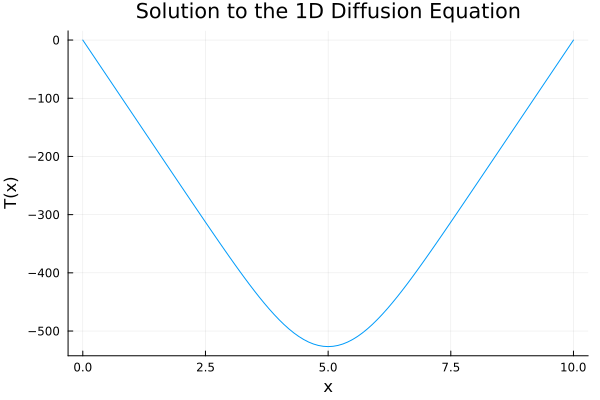

In [9]:
# Mesh parameters
N = 100             # Number of interior points
L = 10.0            # Length of the domain
h = L / N           # Mesh spacing

# Grid point positions
x = range(0, L, length=N+1)

# Boundary conditions
T_a = 0.0
T_b = 0.0

# Construct the matrix A
A = zeros(N+1, N+1)
A[1, 1] = 1.0
A[N+1, N+1] = 1.0
for i in 2:N
    A[i, i-1] = 1 / h^2
    A[i, i] = -2 / h^2
    A[i, i+1] = 1 / h^2
end

# Construct the source vector S
x0 = L / 2       # Center of the Gaussian impulse
sigma = L / 10   # Standard deviation of the Gaussian
Amp = 100        # Amplitude of the impulse
S = Amp * exp.(-0.5 * ((x .- x0) / sigma).^2)
S[1] = T_a
S[N+1] = T_b

# LU decomposition
lu_decomp = lu(A)

# Solving the system using the LU factors
T = lu_decomp \ S

# Visualization of the solution
plot(x, T, title="Solution to the 1D Diffusion Equation", xlabel="x", ylabel="T(x)", legend=false)

### 2. Diffusion Equation in 2D

Having successfully solved the 1D diffusion equation where the source term was modeled as a Gaussian function, we are now ready to extend our approach to a more complex 2D scenario. The 2D diffusion equation can model phenomena such as heat distribution in a rectangular plate where both spatial dimensions have an impact. The equation is represented as follows:

$$
\nabla^2 T = A \exp \left( -\frac{(x - x_0)^2 + (y - y_0)^2 }{2\sigma^2} \right)
$$

Here, $T$ represents the temperature at any given point $(x, y)$ on the plate, and the right-hand side is a Gaussian source centered at $(x_0, y_0)$ with spread $\sigma$. This setup allows us to see how a localized heat source affects the temperature distribution across the domain.


To solve this equation over a 2D domain, we will leverage the Kronecker Product Approach. This approach builds upon our 1D solution by applying it separately along each spatial dimension and then combining the results to cover the entire 2D domain. This method not only simplifies the construction of our system matrix but also efficiently encapsulates the effects of diffusion in both directions.

We assume that the boundary conditions are specified at the edges of the rectangular domain, each side representing a different boundary condition. Here’s how the conditions are applied : 
- $T_{i, N_y+1} = T_{north}$
- $T_{i,1} = T_{south}$
- $T_{1,j}      = T_{west}$
- $T_{N_x+1, j} = T_{east}$


  

#### 2.1. Matrix Construction

 - The matrix $A_{xx}$ applies the 1D diffusion operation along the x-direction for each fixed y-coordinate:
$$
A_{xx} = A_{1D} \otimes I_{N_y + 1}
$$

Here, $A_{1D}$ is our tridiagonal matrix from the 1D case, and $I_{N_y + 1}$ is the identity matrix of size $(N_y + 1) \times (N_y + 1)$. This results in a block diagonal matrix where each block corresponds to a row of grid points in the y-direction.

- Similarly, $A_{yy}$ handles diffusion along the y-direction for each fixed x-coordinate:
$$
A_{yy} = I_{N_x + 1} \otimes A_{1D}
$$

This configuration also results in a block diagonal matrix, but each block corresponds to a column of grid points in the x-direction.

- The combined system matrix $A$ for the 2D scenario, which effectively models diffusion in both dimensions, is the sum of the two matrices:
$$
A = A_{xx} + A_{yy}
$$



In [17]:
# Parameters
Nx = 2
Ny = 2
h = 1.0 / Nx  # Assuming equal spacing for simplicity

# Create a 1D diffusion matrix with Dirichlet boundary conditions
function create_1D_diffusion_matrix(N)
    A_1D = spzeros(N+1, N+1)
    A_1D[1, 1] = 1.0
    A_1D[N+1, N+1] = 1.0
    for i in 2:N
        A_1D[i, i-1] = 1 / h^2
        A_1D[i, i] = -2 / h^2
        A_1D[i, i+1] = 1 / h^2
    end
    return A_1D
end

# Create A_1D for both dimensions
A_1Dx = create_1D_diffusion_matrix(Nx)
A_1Dy = create_1D_diffusion_matrix(Ny)

# Create Axx and Ayy using Kronecker products
Axx = kron(A_1Dx, SparseMatrixCSC(I, Ny+1, Ny+1))  # kron(A, B) takes A, repeats it for each element in B
Ayy = kron(SparseMatrixCSC(I, Nx+1, Nx+1), A_1Dy)

# Combine Axx and Ayy to form the full 2D diffusion matrix A
A = Axx + Ayy

# Display the matrix A
println("Matrix A_1Dx:")
display(A_1Dx)
println("Matrix Axx:")
display(Axx)
println("Matrix A:")
display(A)

Matrix A_1Dx:


3×3 SparseMatrixCSC{Float64, Int64} with 5 stored entries:
 1.0    ⋅    ⋅ 
 4.0  -8.0  4.0
  ⋅     ⋅   1.0

Matrix Axx:


9×9 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 1.0   ⋅    ⋅     ⋅     ⋅     ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅     ⋅     ⋅     ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0    ⋅     ⋅     ⋅    ⋅    ⋅    ⋅ 
 4.0   ⋅    ⋅   -8.0    ⋅     ⋅   4.0   ⋅    ⋅ 
  ⋅   4.0   ⋅     ⋅   -8.0    ⋅    ⋅   4.0   ⋅ 
  ⋅    ⋅   4.0    ⋅     ⋅   -8.0   ⋅    ⋅   4.0
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅    ⋅    ⋅   1.0

Matrix A:


9×9 SparseMatrixCSC{Float64, Int64} with 21 stored entries:
 2.0    ⋅    ⋅     ⋅      ⋅     ⋅    ⋅     ⋅    ⋅ 
 4.0  -7.0  4.0    ⋅      ⋅     ⋅    ⋅     ⋅    ⋅ 
  ⋅     ⋅   2.0    ⋅      ⋅     ⋅    ⋅     ⋅    ⋅ 
 4.0    ⋅    ⋅   -7.0     ⋅     ⋅   4.0    ⋅    ⋅ 
  ⋅    4.0   ⋅    4.0  -16.0   4.0   ⋅    4.0   ⋅ 
  ⋅     ⋅   4.0    ⋅      ⋅   -7.0   ⋅     ⋅   4.0
  ⋅     ⋅    ⋅     ⋅      ⋅     ⋅   2.0    ⋅    ⋅ 
  ⋅     ⋅    ⋅     ⋅      ⋅     ⋅   4.0  -7.0  4.0
  ⋅     ⋅    ⋅     ⋅      ⋅     ⋅    ⋅     ⋅   2.0

#### 2.2. Solving the System

1. **Construct the Source Vector $S$**: The source term must be discretized to match the grid points, consisting of the values from the Gaussian function evaluated at each grid point :
   $$
S(x_i,y_j) = A \exp \left( -\frac{(x_i - x_0)^2 + (y_j - y_0)^2 }{2\sigma^2} \right)
   $$
We also set the values at the boundary directly to the specified boundary conditions, overriding the values that would otherwise be calculated by the Gaussian function.

3. **Solve the Linear System $AX = S$**: The solution vector $X$, which represents the flattened matrix of temperature or concentration values, is obtained by solving this system.